# Cadence Effects

In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import sncosmo
from astropy.table import Table

from sn_analysis import filters
from sn_analysis import modeling
from sn_analysis import plasticc_data

filters.register_lsst_filters(force=True)


../sn_analysis/plasticc_data.py:20: UserWarning: ``plasticc_sim_dir`` is not set in environment. Defaulting to /mnt/md0/snsims
  warn(f'``plasticc_sim_dir`` is not set in environment. Defaulting to {default_data_dir}')


## Atmospheric Variability


In [2]:
# Todo

## Simulating Light-Curves

Instead of evaluating different cadences from scratch, we rely on data from the PLaSTICC simulations.

In [3]:
plasticc_data.get_available_cadences()


['alt_sched_rolling',
 'rolling_mix_10yrs_opsim',
 'kraken_2026',
 'rolling_10yrs_opsim',
 'alt_sched',
 'nexus_2097']

The full simulation datasets include simulations for multiple models. Since we don't need this extra information, we only use data for simulated normal SNe (Model number 11).

In [4]:
plasticc_lc = next(plasticc_data.iter_lc_for_cadence_model('alt_sched_rolling', model=11))


In [5]:
plasticc_lc.meta


OrderedDict([('SUBSURVEY', '                                        '),
             ('SNID', '8153737         '),
             ('IAUC', 'NULL            '),
             ('FAKE', 2),
             ('RA', 253.055557),
             ('DECL', -60.056278),
             ('PIXSIZE', 0.20000000298023224),
             ('NXPIX', -9),
             ('NYPIX', -9),
             ('CCDNUM', 0),
             ('SNTYPE', 111),
             ('NOBS', 199),
             ('PTROBS_MIN', 1),
             ('PTROBS_MAX', 199),
             ('MWEBV', 0.15503360331058502),
             ('MWEBV_ERR', 0.007751679979264736),
             ('REDSHIFT_HELIO', 0.5014199614524841),
             ('REDSHIFT_HELIO_ERR', 0.23810000717639923),
             ('REDSHIFT_FINAL', 0.5016952753067017),
             ('REDSHIFT_FINAL_ERR', 0.23810000717639923),
             ('VPEC', 0.0),
             ('VPEC_ERR', 300.0),
             ('HOSTGAL_OBJID', 277268),
             ('HOSTGAL_PHOTOZ', 0.5014199614524841),
             ('HOSTGA

In [6]:
plasticc_lc


MJD,FLT,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,SKY_SIG,ZEROPT,SIM_MAGOBS
float64,str2,str12,int32,float32,float32,float32,float32,float32,float32,float32
60750.3891,z,NULL,0,0.0,-9.732752,18.38342,1.72,59.76,30.97,98.75439
60750.4025,Y,NULL,0,0.0,41.852177,45.757626,1.91,57.62,30.02,98.79263
60751.3921,z,NULL,0,0.0,19.945679,18.32146,1.75,57.91,30.96,98.75439
60751.4056,Y,NULL,0,0.0,-20.76702,38.440018,1.5,61.71,30.02,98.79263
60752.3933,z,NULL,0,0.0,15.96132,14.578538,1.4,58.11,30.97,98.75439
60752.407,Y,NULL,0,0.0,-5.417403,42.153595,1.6,64.03,30.03,98.79263
60753.3966,Y,NULL,0,0.0,-8.590908,19.21085,1.2,77.63,30.78,98.79263
60754.3856,r,NULL,0,0.0,-21.428425,9.080835,1.41,55.73,31.61,98.57609
60754.3973,z,NULL,0,0.0,-1.4168533,11.824018,1.23,53.75,30.97,98.75439


As as first step, we reformat the data to be compatible with `sncosmo`.

In [7]:
def iter_sncosmo_lcs(cadence):
    """Iterate over """
    for pointing in plasticc_data.iter_lc_for_cadence_model(cadence):
        lc = Table({
            'time': pointing['MJD'],
            'band': ['lsst_hardware_' + f.lower().strip() for f in pointing['FLT']],
            'flux': pointing['FLUXCAL'],
            'fluxerr': pointing['FLUXCALERR'],
            'zp': pointing['ZEROPT'],
            'photflag': pointing['PHOTFLAG']
        })
        
        lc['zpsys'] = 'AB'
        lc.meta = pointing.meta
        yield lc
        

In [8]:
formatted_lc = next(iter_sncosmo_lcs('alt_sched_rolling'))


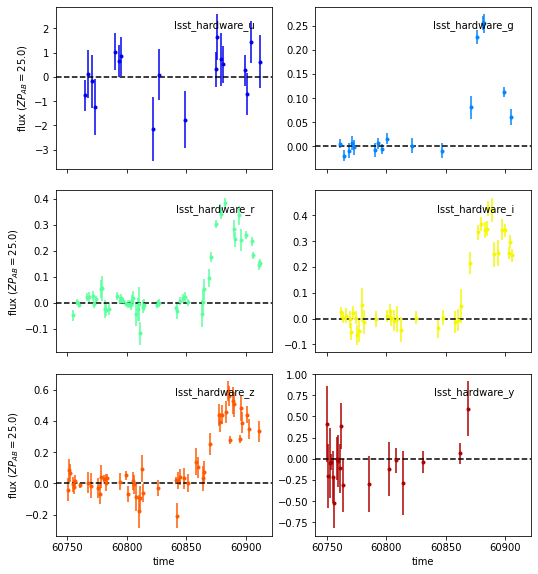

In [9]:
sncosmo.plot_lc(formatted_lc);


We note that many of the above data points are flagged as being non-detections (`photflag == 0`). Here are just the detections.

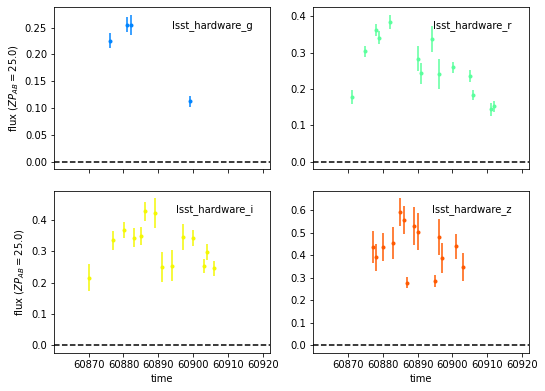

In [10]:
sncosmo.plot_lc(formatted_lc[formatted_lc['photflag'] != 0]);


Since we need to add in our own atmospheric variability the pre-tabulated flux values above are of limited use. However, we can use the PLaSTICC light-curves to establish the cadence and model parameters for each simulated light-curve. This information can then be used to simulate our own light-curves with `sncosmo`.

In [11]:
model = sncosmo.Model('Salt2')
observations = formatted_lc[['band', 'time', 'zp', 'zpsys']]
observations['gain'] = 10
observations['skynoise'] = 500

params = [{
    't0': formatted_lc.meta['PEAKMJD'], 
    'x0': formatted_lc.meta['SIM_SALT2x0'], 
    'x1': formatted_lc.meta['SIM_SALT2x1'],
    'c': formatted_lc.meta['SIM_SALT2c'], 
    'z': formatted_lc.meta['REDSHIFT_FINAL']
}]

sncosmo_lc = sncosmo.realize_lcs(observations, model, params)[0]


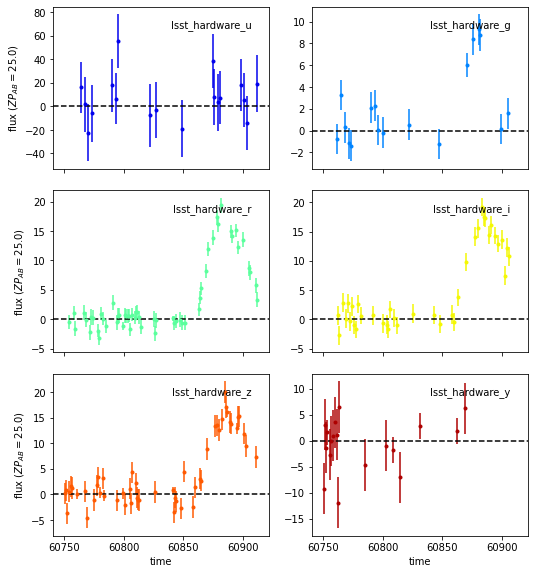

In [12]:
sncosmo.plot_lc(sncosmo_lc);


In [ ]:
fluxerr = np.sqrt(skynoise ** 2 + np.abs(flux) / gain)
